# preparing

In [1]:
from google.colab import drive

# This will prompt you to click on a link and provide an authorization code
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9848c03054985fd08a301d8a4f6e1d78648ab722274613dd88719ca301af86b0
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import zipfile

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/worldcitiespop.zip'

# Specify the directory where you want to extract the contents
extracted_dir = '/content'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Print the path to the extracted directory
print("Files extracted to:", extracted_dir)


Files extracted to: /content


# using RDD

In [4]:
from pyspark import SparkContext

# Create a Spark Context
sc = SparkContext("local[*]")

# Load the data from Google Drive as an RDD
file_path = "/content/worldcitiespop.txt"
rdd = sc.textFile(file_path)

# Extract header
header = rdd.first()

# Filter out the header from the RDD
data_rdd = rdd.filter(lambda row: row != header)

# Show the first few rows of the data RDD
for row in data_rdd.take(5):
    print(row)


ad,aixas,Aix�s,06,,42.4833333,1.4666667
ad,aixirivali,Aixirivali,06,,42.4666667,1.5
ad,aixirivall,Aixirivall,06,,42.4666667,1.5
ad,aixirvall,Aixirvall,06,,42.4666667,1.5
ad,aixovall,Aixovall,06,,42.4666667,1.4833333


## simple cleaning

In [5]:
from pyspark import SparkContext

# Define the minimum population threshold
min_population = 0

# Function to filter valid lines based on population
def is_valid_line(row):
    try:
        # Split the row into columns
        columns = row.split(',')

        # Extract the population column
        population = int(columns[4])

        # Check if the population is greater than or equal to the threshold
        return population >= min_population
    except:
        return False

# Filter out invalid lines based on population
valid_data_rdd = data_rdd.filter(lambda row: row != header and is_valid_line(row))

# Show the first few rows of the valid data RDD
for row in valid_data_rdd.take(5):
    print(row)


ad,andorra la vella,Andorra la Vella,07,20430,42.5,1.5166667
ad,canillo,Canillo,02,3292,42.5666667,1.6
ad,encamp,Encamp,03,11224,42.5333333,1.5833333
ad,la massana,La Massana,04,7211,42.55,1.5166667
ad,les escaldes,Les Escaldes,08,15854,42.5,1.5333333


In [16]:
# Count the number of records in the valid data RDD
record_count = valid_data_rdd.count()


# Print the count of valid records
print(f"Number of valid records: {record_count}")

Number of valid records: 47980


## statistics

In [17]:
# Parse the CSV data into a key-value pair RDD, where the key is the city and the value is the population
city_population_rdd = valid_data_rdd.map(lambda line: line.split(',')) \
    .map(lambda fields: (fields[2], int(fields[4]) if fields[4].isdigit() else 0))

# Filter out entries with population 0
filtered_city_population_rdd = city_population_rdd.filter(lambda x: x[1] > 0)

# Compute the statistics
population_stats = filtered_city_population_rdd.values().stats()

# Display the statistics
print("Minimum Population: {}".format(population_stats.min()))
print("Maximum Population: {}".format(population_stats.max()))
print("Total Population: {}".format(population_stats.sum()))
print("Average Population: {}".format(population_stats.mean()))


Minimum Population: 7.0
Maximum Population: 31480498.0
Total Population: 2289584998.999997
Average Population: 47719.57063359727


## Histograms

In [8]:
# Step 1: Parse the data into tuples (population, 1)
parsed_data = valid_data_rdd.map(lambda line: line.split(",")).filter(lambda parts: len(parts) == 7)
population_data = parsed_data.map(lambda parts: (int(parts[4]), 1))

# Step 2: Group the data by the logarithmic scale of city populations
# Use logarithmic scale for binning
log_bins = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000, float('inf')]
population_bins = population_data.map(lambda x: (next(i-1 for i, v in enumerate(log_bins) if x[0] < v), x[1]))

# Step 3: Count the number of cities in each group
histogram = population_bins.reduceByKey(lambda x, y: x + y)

# Step 4: Sort the results by bin
sorted_histogram = histogram.sortByKey()

# Step 5: Collect the result
result = sorted_histogram.collect()

# Print the sorted result
print(result)

[(0, 5), (1, 174), (2, 2187), (3, 20537), (4, 21550), (5, 3248), (6, 269), (7, 10)]


## top k

In [48]:
# Step 1: Parse the CSV data into a structured format
def parse_csv(line):
    fields = line.split(",")
    country, city, accent_city, region, population, latitude, longitude = fields
    return (country, city, accent_city, region, int(population), latitude, longitude)

parsed_data_rdd = valid_data_rdd.map(parse_csv)

# Step 2: Transform the data to create key-value pairs
# Key: Population, Value: City Information
population_city_rdd = parsed_data_rdd.map(lambda x: (x[4], x))
k=10
# Step 3: Use shufflable transformation to find the top 10 cities by population
top_10_cities = population_city_rdd.sortByKey(ascending=False).take(k)

# Display the result
for i, (population, (country, city, accent_city, region, int_population, latitude, longitude)) in enumerate(top_10_cities, 1):
    print(f"{i}.country: {country}, City: {city},region: {region}, Population: {int_population}, Location: {latitude}, {longitude}")



1.country: jp, City: tokyo,region: 40, Population: 31480498, Location: 35.685, 139.751389
2.country: cn, City: shanghai,region: 23, Population: 14608512, Location: 31.045556, 121.399722
3.country: in, City: bombay,region: 16, Population: 12692717, Location: 18.975, 72.825833
4.country: pk, City: karachi,region: 05, Population: 11627378, Location: 24.9056, 67.0822
5.country: in, City: delhi,region: 07, Population: 10928270, Location: 28.666667, 77.216667
6.country: in, City: new delhi,region: 07, Population: 10928270, Location: 28.6, 77.2
7.country: ph, City: manila,region: D9, Population: 10443877, Location: 14.6042, 120.9822
8.country: ru, City: moscow,region: 48, Population: 10381288, Location: 55.752222, 37.615556
9.country: kr, City: seoul,region: 11, Population: 10323448, Location: 37.5985, 126.9783
10.country: br, City: sao paulo,region: 27, Population: 10021437, Location: -23.473293, -46.665803


## percentage

In [10]:
# Assuming the columns are separated by commas, split each line and create a tuple
# with the city and its population
city_population_rdd = valid_data_rdd.map(lambda line: line.split(",")).map(lambda cols: (cols[2], int(cols[4])))

# Calculate the total population
total_population = city_population_rdd.values().sum()

# Define the value of K (e.g., top 10 cities)
K = 10

# Get the top K populous cities
top_K_cities = city_population_rdd.takeOrdered(K, key=lambda x: -x[1])

# Calculate the total population represented by the top K cities
total_population_top_K = sum(city[1] for city in top_K_cities)

# Calculate the percentage
percentage_top_K = (total_population_top_K / total_population) * 100

# Print the result
print(f"The top {K} cities represent {percentage_top_K:.2f}% of the total population globally.")


The top 10 cities represent 5.83% of the total population globally.


## region population

In [87]:
# Parse the data and extract relevant columns
def parse_line(line):
    fields = line.split(',')
    return (fields[3], int(fields[4]))

# Map each line to a tuple of (Region, Population)
region_population_rdd = valid_data_rdd.map(parse_line)

# Use reduceByKey to calculate the total population for each region
total_population_rdd = region_population_rdd.reduceByKey(lambda x, y: x + y)

# Find the region with the highest population using sortBy
total_population_region = total_population_rdd.sortBy(lambda x: x[1], ascending=False)
max_population_region = total_population_region.first()

# Display the result
print("Region with the highest population:")
print("Region: {}, Total Population: {}".format(max_population_region[0], max_population_region[1]))
print("Total population by region:")
# Collect the results and iterate over them
result_list = total_population_region.collect()
for i, (region, population) in enumerate(result_list, 1):
    print(f"{i}. Region: {region}, Population: {population}")


Region with the highest population:
Region: 04, Total Population: 112249869
Total population by region:
1. Region: 04, Population: 112249869
2. Region: 07, Population: 99634521
3. Region: 02, Population: 90271668
4. Region: 05, Population: 88272385
5. Region: 16, Population: 71422264
6. Region: 08, Population: 69386610
7. Region: 09, Population: 68742631
8. Region: 11, Population: 61477197
9. Region: 01, Population: 60187116
10. Region: 06, Population: 58191980
11. Region: 15, Population: 57366367
12. Region: 10, Population: 52912641
13. Region: 13, Population: 50762945
14. Region: 19, Population: 49067537
15. Region: 23, Population: 48056875
16. Region: 30, Population: 47565528
17. Region: 25, Population: 44541463
18. Region: 12, Population: 44192013
19. Region: 40, Population: 43122879
20. Region: 27, Population: 42540035
21. Region: 03, Population: 40425352
22. Region: 34, Population: 37485180
23. Region: 36, Population: 37468678
24. Region: 28, Population: 34430828
25. Region: 21, 

## sum > value

In [12]:
# Define the specified value for population sum
specified_population_sum = 1000000  # Change this value as needed

# Parse the CSV data and filter out invalid entries
def parse_and_filter(line):
    try:
        fields = line.split(",")
        country = fields[0]
        population = int(fields[4])
        return (country, population)
    except:
        return ("Invalid", 0)

# Apply the transformation to parse and filter the data
filtered_data_rdd = valid_data_rdd.map(parse_and_filter).filter(lambda x: x[0] != "Invalid")

# Compute the sum of populations for each country
sum_population_by_country_rdd = filtered_data_rdd.reduceByKey(lambda x, y: x + y)

# Filter countries based on the specified population sum
result_countries_rdd = sum_population_by_country_rdd.filter(lambda x: x[1] > specified_population_sum)

# Collect the result and print the output
result_countries = result_countries_rdd.collect()
for country, population_sum in result_countries:
    print(f"Country: {country}, Population Sum: {population_sum}")


Country: at, Population Sum: 4475257
Country: bg, Population Sum: 4858204
Country: br, Population Sum: 133449921
Country: cf, Population Sum: 1721313
Country: cg, Population Sum: 1456811
Country: cl, Population Sum: 11618910
Country: cm, Population Sum: 8336059
Country: cn, Population Sum: 218884084
Country: es, Population Sum: 27772466
Country: gr, Population Sum: 7273653
Country: id, Population Sum: 62440459
Country: il, Population Sum: 3845875
Country: kr, Population Sum: 10323448
Country: kz, Population Sum: 6703821
Country: lr, Population Sum: 1152668
Country: ml, Population Sum: 2477595
Country: mm, Population Sum: 11283081
Country: mn, Population Sum: 1168089
Country: no, Population Sum: 2762949
Country: np, Population Sum: 2926805
Country: py, Population Sum: 2833416
Country: ru, Population Sum: 109505345
Country: sl, Population Sum: 1959652
Country: sy, Population Sum: 4796329
Country: ug, Population Sum: 3602167
Country: us, Population Sum: 179123400
Country: uy, Population S

## avg population > trsh

In [13]:
# Define the minimum population threshold
population_threshold = 100000  # Set your desired threshold

# Parse the CSV data and filter cities with population above the threshold
parsed_data_rdd = valid_data_rdd.map(lambda line: line.split(","))
filtered_data_rdd = parsed_data_rdd.filter(lambda fields: int(fields[4]) > population_threshold)

# Create a key-value pair with (Country, (Population, 1))
country_population_rdd = filtered_data_rdd.map(lambda fields: (fields[0], (int(fields[4]), 1)))

# Use combineByKey to calculate the sum and count of populations for each country
sum_count_rdd = country_population_rdd.combineByKey(
    lambda value: (value[0], 1),
    lambda x, value: (x[0] + value[0], x[1] + 1),
    lambda x, y: (x[0] + y[0], x[1] + y[1])
)

# Calculate the average population for each country
average_population_rdd = sum_count_rdd.mapValues(lambda x: x[0] / x[1])

# Collect the results
results = average_population_rdd.collect()

# Print the results
for country, avg_population in results:
    print(f"Country: {country}, Average Population: {avg_population}")


Country: at, Average Population: 446116.2
Country: bg, Average Population: 331211.4285714286
Country: br, Average Population: 410966.37272727274
Country: cf, Average Population: 684190.0
Country: cg, Average Population: 1115773.0
Country: cl, Average Population: 381148.0
Country: cm, Average Population: 399620.4
Country: cn, Average Population: 502467.7545691906
Country: es, Average Population: 319685.76
Country: gq, Average Population: 164537.5
Country: gr, Average Population: 251161.85714285713
Country: id, Average Population: 339203.0680272109
Country: il, Average Population: 243992.1
Country: is, Average Population: 113907.0
Country: kr, Average Population: 10323448.0
Country: kz, Average Population: 314176.6
Country: lr, Average Population: 935427.0
Country: me, Average Population: 156988.0
Country: ml, Average Population: 516993.6666666667
Country: mm, Average Population: 437127.45
Country: mn, Average Population: 844786.0
Country: mr, Average Population: 709835.0
Country: mu, Av

## city pop>avg country

In [19]:
# Step 1: Parse the CSV data into key-value pairs
def parse_line(line):
    fields = line.split(',')
    country = fields[0]
    city = fields[1]
    population = int(fields[4])
    return (country, (city, population))

# Apply the parse_line function to each line in the RDD
parsed_data_rdd = valid_data_rdd.map(parse_line)

# Step 2: Calculate the average population for each country
country_population_avg_rdd = parsed_data_rdd \
    .mapValues(lambda x: (x[1], 1)) \
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
    .mapValues(lambda x: x[0] / x[1])

# Step 3: Filter cities with populations above their respective country averages
result_rdd = parsed_data_rdd.join(country_population_avg_rdd) \
    .filter(lambda x: x[1][0][1] > x[1][1])

# Display the result
result_rdd.collect()


[('an', (('willemstad', 97590), 8399.142857142857)),
 ('at', (('amstetten', 22832), 20250.031674208145)),
 ('at', (('baden', 24893), 20250.031674208145)),
 ('at', (('bregenz', 26928), 20250.031674208145)),
 ('at', (('dornbirn', 43013), 20250.031674208145)),
 ('at', (('feldkirch', 29446), 20250.031674208145)),
 ('at', (('graz', 222326), 20250.031674208145)),
 ('at', (('innsbruck', 112467), 20250.031674208145)),
 ('at', (('kapfenberg', 21819), 20250.031674208145)),
 ('at', (('klagenfurt', 90610), 20250.031674208145)),
 ('at', (('klosterneuburg', 24843), 20250.031674208145)),
 ('at', (('krems', 24092), 20250.031674208145)),
 ('at', (('leoben', 24809), 20250.031674208145)),
 ('at', (('leonding', 22736), 20250.031674208145)),
 ('at', (('linz', 181163), 20250.031674208145)),
 ('at', (('modling', 20710), 20250.031674208145)),
 ('at', (('salzburg', 145310), 20250.031674208145)),
 ('at', (('sankt polten', 49000), 20250.031674208145)),
 ('at', (('steyr', 39567), 20250.031674208145)),
 ('at', (('

## Re-cleaning

#### cleaning

In [51]:
# Parse the RDD into a structured format
def parse_line(line):
    fields = line.split(",")
    return ((math.floor(float(fields[5])*10)/10, math.floor(float(fields[6])*10)/10,fields[0],fields[3]), fields[0], fields[1], fields[2], fields[3], int(fields[4]))

parsed_data_rdd = valid_data_rdd.map(parse_line)

# Define a function to keep the record with the highest population within each key
# Define a function to keep the record with the highest population within each key
def reduce_duplicates(a, b):
    if a[5] > b[5]:
        return b
    else:
        return a


# Use reduceByKey to eliminate duplicates based on the highest population within each key
result_rdd = parsed_data_rdd.map(lambda x: (x[0], x)).reduceByKey(reduce_duplicates).values()

# Print the result
for row in result_rdd.collect():
    print("City: {}, Population: {}, Location: {}, {}".format(row[1], row[5], row[0][0], row[0][1]))

Streaming output truncated to the last 5000 lines.
City: hu, Population: 3155, Location: 47.3, 19.8
City: hu, Population: 3040, Location: 47.3, 19.2
City: hu, Population: 4345, Location: 47.3, 21.3
City: hu, Population: 5199, Location: 46.7, 17.5
City: hu, Population: 1985, Location: 47.2, 18.6
City: hu, Population: 2463, Location: 47.8, 19.8
City: hu, Population: 31957, Location: 47.6, 21.5
City: hu, Population: 12892, Location: 47.6, 21.6
City: hu, Population: 18032, Location: 47.8, 21.4
City: hu, Population: 2312, Location: 47.8, 17.3
City: hu, Population: 10754, Location: 47.5, 19.4
City: hu, Population: 2709, Location: 47.3, 20.0
City: hu, Population: 8107, Location: 47.6, 19.9
City: hu, Population: 3125, Location: 47.0, 20.0
City: hu, Population: 5741, Location: 47.4, 20.2
City: hu, Population: 3968, Location: 47.8, 21.9
City: hu, Population: 2845, Location: 48.1, 19.7
City: hu, Population: 1984, Location: 48.3, 21.8
City: hu, Population: 106062, Location: 46.9, 19.7
City: hu, Po

In [52]:
result_rdd.take(5)

[((42.5, 1.5, 'ad', '08'), 'ad', 'les escaldes', 'Les Escaldes', '08', 15854),
 ((42.4, 1.5, 'ad', '06'),
  'ad',
  'sant julia de loria',
  'Sant Juli� de L�ria',
  '06',
  8020),
 ((25.2, 55.3, 'ae', '03'), 'ae', 'dubai', 'Dubai', '03', 1137376),
 ((35.0, 69.1, 'af', '40'), 'af', 'carikar', 'Carikar', '40', 53693),
 ((32.3, 62.1, 'af', '06'), 'af', 'farah', 'Farah', '06', 43574)]

#### statistics

In [53]:
# Count the number of records in the valid data RDD
record_count = result_rdd.count()


# Print the count of valid records
print(f"Number of valid records: {record_count}")

Number of valid records: 38510


In [55]:
# Extract population values for statistics
population_stats = result_rdd.map(lambda row: row[5])

# Display the statistics
print("Minimum Population: {}".format(population_stats.min()))
print("Maximum Population: {}".format(population_stats.max()))
print("Total Population: {}".format(population_stats.sum()))
print("Average Population: {}".format(population_stats.mean()))

Minimum Population: 7
Maximum Population: 31480498
Total Population: 1933830945
Average Population: 50216.331991690415


#### histograms

In [42]:
# Step 1: Parse the data into tuples (population, 1)
population_data = result_rdd.map(lambda row: (row[0][5], 1))

# Step 2: Group the data by the logarithmic scale of city populations
# Use logarithmic scale for binning
log_bins = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000, float('inf')]
population_bins = population_data.map(lambda x: (next(i-1 for i, v in enumerate(log_bins) if x[0] < v), x[1]))

# Step 3: Count the number of cities in each group
histogram = population_bins.reduceByKey(lambda x, y: x + y)

# Step 4: Sort the results by bin
sorted_histogram = histogram.sortByKey()

# Step 5: Collect the result
result = sorted_histogram.collect()

# Print the sorted result
print(result)


[(0, 4), (1, 77), (2, 1500), (3, 15184), (4, 17882), (5, 2781), (6, 242), (7, 8)]


#### top k

In [63]:
# Define a function to format the result_rdd into the desired format
def format_result(row):
    return (row[1], row[2], row[3], row[4], row[5], row[0][0], row[0][1])

# Apply the format_result function to each element in result_rdd
final_rdd = result_rdd.map(format_result)

# Print the first 5 rows of final_rdd
for row in final_rdd.take(5):
    print("Country: {}, City: {}, AccentCity: {}, Region: {}, Population: {}, Latitude: {}, Longitude: {}".format(row[0], row[1], row[2], row[3], row[4], row[5], row[6]))


Country: ad, City: les escaldes, AccentCity: Les Escaldes, Region: 08, Population: 15854, Latitude: 42.5, Longitude: 1.5
Country: ad, City: sant julia de loria, AccentCity: Sant Juli� de L�ria, Region: 06, Population: 8020, Latitude: 42.4, Longitude: 1.5
Country: ae, City: dubai, AccentCity: Dubai, Region: 03, Population: 1137376, Latitude: 25.2, Longitude: 55.3
Country: af, City: carikar, AccentCity: Carikar, Region: 40, Population: 53693, Latitude: 35.0, Longitude: 69.1
Country: af, City: farah, AccentCity: Farah, Region: 06, Population: 43574, Latitude: 32.3, Longitude: 62.1


In [64]:

# Step 2: Transform the data to create key-value pairs
# Key: Population, Value: City Information
population_city_rdd = final_rdd.map(lambda x: (x[4], x))
k=10
# Step 3: Use shufflable transformation to find the top 10 cities by population
top_10_cities = population_city_rdd.sortByKey(ascending=False).take(k)

# Display the result
for i, (population, (country, city, accent_city, region, int_population, latitude, longitude)) in enumerate(top_10_cities, 1):
    print(f"{i}.country: {country}, City: {city},region: {region}, Population: {int_population}, Location: {latitude}, {longitude}")



1.country: jp, City: tokyo,region: 40, Population: 31480498, Location: 35.6, 139.7
2.country: cn, City: shanghai,region: 23, Population: 14608512, Location: 31.0, 121.3
3.country: in, City: bombay,region: 16, Population: 12692717, Location: 18.9, 72.8
4.country: pk, City: karachi,region: 05, Population: 11627378, Location: 24.9, 67.0
5.country: in, City: delhi,region: 07, Population: 10928270, Location: 28.6, 77.2
6.country: ph, City: manila,region: D9, Population: 10443877, Location: 14.6, 120.9
7.country: ru, City: moscow,region: 48, Population: 10381288, Location: 55.7, 37.6
8.country: kr, City: seoul,region: 11, Population: 10323448, Location: 37.5, 126.9
9.country: br, City: sao paulo,region: 27, Population: 10021437, Location: -23.5, -46.7
10.country: tr, City: istanbul,region: 34, Population: 9797536, Location: 41.0, 28.9


#### percentage

In [66]:
final_rdd.take(5)

[('ad', 'les escaldes', 'Les Escaldes', '08', 15854, 42.5, 1.5),
 ('ad', 'sant julia de loria', 'Sant Juli� de L�ria', '06', 8020, 42.4, 1.5),
 ('ae', 'dubai', 'Dubai', '03', 1137376, 25.2, 55.3),
 ('af', 'carikar', 'Carikar', '40', 53693, 35.0, 69.1),
 ('af', 'farah', 'Farah', '06', 43574, 32.3, 62.1)]

In [69]:
# Assuming final_rdd is the RDD with the desired format (Country, City, AccentCity, Region, Population, Latitude, Longitude)

# Define the top K value
top_k = 5

# Sort final_rdd by Population in descending order
sorted_rdd = final_rdd.sortBy(lambda x: x[4], ascending=False)

# Take the top K populous cities
top_k_cities = sorted_rdd.take(top_k)

# Calculate the total population
total_population = final_rdd.map(lambda x: x[4]).sum()

# Calculate the population of the top K cities
top_k_population = sum(city[4] for city in top_k_cities)

# Calculate the percentage
percentage_top_k_population = (top_k_population / total_population) * 100

# Print the result
print("Percentage of total population represented by the top {} populous cities: {:.2f}%".format(top_k, percentage_top_k_population))


Percentage of total population represented by the top 5 populous cities: 4.21%


#### region population

In [90]:
# Map the final_rdd to a new RDD with key-value pairs where the key is the region and the value is the population
region_population_rdd = final_rdd.map(lambda x: (x[3], x[4]))

# Use reduceByKey to calculate the total population for each region
total_population_rdd = region_population_rdd.reduceByKey(lambda a, b: a + b)

# Find the region with the highest population
max_population_region = total_population_rdd.max(lambda x: x[1])

# Print the region with the highest population
print("\nRegion with the highest population:")
print("Region: {}, Total Population: {}".format(max_population_region[0], max_population_region[1]))

# Order the total population of each region by population in descending order
ordered_total_population_rdd = total_population_rdd.sortBy(lambda x: x[1], ascending=False)

# Print the total population of each region in descending order
print("\nTotal population of each region (ordered by population in descending order):")
for row in ordered_total_population_rdd.collect():
    print("Region: {}, Total Population: {}".format(row[0], row[1]))



Region with the highest population:
Region: 04, Total Population: 95893419

Total population of each region (ordered by population in descending order):
Region: 04, Total Population: 95893419
Region: 02, Total Population: 83399132
Region: 05, Total Population: 81248168
Region: 07, Total Population: 75975207
Region: 08, Total Population: 62700707
Region: 16, Total Population: 62699388
Region: 11, Total Population: 54529402
Region: 06, Total Population: 53469380
Region: 09, Total Population: 52841233
Region: 01, Total Population: 50468386
Region: 10, Total Population: 47092683
Region: 15, Total Population: 46829081
Region: 19, Total Population: 44188922
Region: 13, Total Population: 43253826
Region: 23, Total Population: 42607793
Region: 12, Total Population: 41011644
Region: 40, Total Population: 40524146
Region: 30, Total Population: 38080442
Region: 27, Total Population: 36956815
Region: 25, Total Population: 36229585
Region: 36, Total Population: 33383755
Region: 03, Total Populatio

#### sum> value

In [71]:
# Define the specified population threshold
specified_population = 10000000  # Adjust this value as needed

# Create a new RDD with the key as the country and the value as the population of the city
country_population_rdd = final_rdd.map(lambda x: (x[0], x[4]))

# Use reduceByKey to calculate the sum of populations for each country
country_sum_population_rdd = country_population_rdd.reduceByKey(lambda a, b: a + b)

# Filter the countries based on the specified population threshold
selected_countries_rdd = country_sum_population_rdd.filter(lambda x: x[1] > specified_population)

# Print the result
for country in selected_countries_rdd.collect():
    print("Country: {}, Sum of Populations: {}".format(country[0], country[1]))


Country: br, Sum of Populations: 122529195
Country: cl, Sum of Populations: 11446732
Country: cn, Sum of Populations: 215141618
Country: es, Sum of Populations: 22901511
Country: id, Sum of Populations: 51283581
Country: mm, Sum of Populations: 11283081
Country: ru, Sum of Populations: 95510179
Country: us, Sum of Populations: 121069136
Country: za, Sum of Populations: 28161751
Country: kr, Sum of Populations: 10323448
Country: ar, Sum of Populations: 15416375
Country: au, Sum of Populations: 17551678
Country: co, Sum of Populations: 25794817
Country: ir, Sum of Populations: 27990737
Country: ph, Sum of Populations: 29381767
Country: pk, Sum of Populations: 46267015
Country: pl, Sum of Populations: 18957580
Country: cd, Sum of Populations: 16430726
Country: gb, Sum of Populations: 36245031
Country: in, Sum of Populations: 214737906
Country: ng, Sum of Populations: 45178938
Country: th, Sum of Populations: 14977616
Country: ua, Sum of Populations: 17606973
Country: bd, Sum of Population

#### avg population > threshold

In [72]:
# Set the population threshold
population_threshold = 100000

# Filter final_rdd to include only cities with population above the threshold
filtered_rdd = final_rdd.filter(lambda x: x[4] > population_threshold)

# Map the data to (Country, (Population, 1)) to calculate the sum and count for each country
country_population_rdd = filtered_rdd.map(lambda x: (x[0], (x[4], 1)))

# Reduce by key to calculate the sum and count for each country
sum_count_rdd = country_population_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Calculate the average population for each country
average_population_rdd = sum_count_rdd.map(lambda x: (x[0], x[1][0] / x[1][1]))

# Print the result
for row in average_population_rdd.collect():
    print("Country: {}, Average Population: {:.2f}".format(row[0], row[1]))


Country: at, Average Population: 657601.33
Country: bg, Average Population: 331211.43
Country: br, Average Population: 416413.68
Country: cl, Average Population: 381148.00
Country: cm, Average Population: 399620.40
Country: cn, Average Population: 506517.73
Country: es, Average Population: 348588.63
Country: gq, Average Population: 164537.50
Country: id, Average Population: 364059.03
Country: il, Average Population: 271553.83
Country: kz, Average Population: 314176.60
Country: mm, Average Population: 437127.45
Country: np, Average Population: 241668.57
Country: ru, Average Population: 439922.59
Country: sy, Average Population: 620188.86
Country: us, Average Population: 383695.39
Country: uy, Average Population: 705266.00
Country: ye, Average Population: 550744.00
Country: za, Average Population: 468306.26
Country: cg, Average Population: 1115773.00
Country: gr, Average Population: 128760.00
Country: kr, Average Population: 10323448.00
Country: me, Average Population: 156988.00
Country:

#### city population > country average population

In [73]:
# Calculate average population for each country
country_population_avg = final_rdd.map(lambda x: (x[0], (x[4], 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda x: x[0] / x[1])

# Broadcast the average population to all nodes
broadcast_avg = sc.broadcast(dict(country_population_avg.collect()))

# Filter cities with population above their respective country's average
above_avg_cities = final_rdd.filter(lambda x: x[4] > broadcast_avg.value[x[0]])

# Print the identified cities
for row in above_avg_cities.collect():
    print("Country: {}, City: {}, Population: {}, Latitude: {}, Longitude: {}".format(row[0], row[1], row[4], row[5], row[6]))


Streaming output truncated to the last 5000 lines.
Country: ua, City: torez, Population: 68037, Latitude: 48.0, Longitude: 38.5
Country: ua, City: volnovakha, Population: 23731, Latitude: 47.6, Longitude: 37.4
Country: ua, City: yevpatoriya, Population: 105222, Latitude: 45.2, Longitude: 33.3
Country: ua, City: zdolbuniv, Population: 23697, Latitude: 50.5, Longitude: 26.2
Country: ua, City: zhovti vody, Population: 51559, Latitude: 48.3, Longitude: 33.5
Country: ug, City: mukono, Population: 67303, Latitude: 0.3, Longitude: 32.7
Country: ug, City: tororo, Population: 47729, Latitude: 0.6, Longitude: 34.1
Country: us, City: montgomery, Population: 198325, Latitude: 32.3, Longitude: -86.3
Country: us, City: catalina foothills, Population: 71589, Latitude: 32.2, Longitude: -111.0
Country: us, City: glendale, Population: 240112, Latitude: 33.5, Longitude: -112.2
Country: us, City: yuma, Population: 84316, Latitude: 32.7, Longitude: -114.7
Country: us, City: fort smith, Population: 81985, L

# using df

In [75]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
# Import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
print(spark)
# Import a Spark function from library
from pyspark.sql.functions import col
# Load the data from Google Drive
file_path = "/content/worldcitiespop.txt"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show()


+-------+------------------+------------------+------+----------+----------+---------+
|Country|              City|        AccentCity|Region|Population|  Latitude|Longitude|
+-------+------------------+------------------+------+----------+----------+---------+
|     ad|             aixas|             Aix�s|    06|      NULL|42.4833333|1.4666667|
|     ad|        aixirivali|        Aixirivali|    06|      NULL|42.4666667|      1.5|
|     ad|        aixirivall|        Aixirivall|    06|      NULL|42.4666667|      1.5|
|     ad|         aixirvall|         Aixirvall|    06|      NULL|42.4666667|      1.5|
|     ad|          aixovall|          Aixovall|    06|      NULL|42.4666667|1.4833333|
|     ad|           andorra|           Andorra|    07|      NULL|      42.5|1.5166667|
|     ad|  andorra la vella|  Andorra la Vella|    07|     20430|      42.5|1.5166667|
|     ad|   andorra-vieille|   Andorra-Vieille|    07|      NULL|      42.5|1.5166667|
|     ad|           andorre|           Ando

In [76]:
df.count()

3173958

## simple cleaning

In [77]:
# Clean the data by removing rows with non-integer values for populations
cleaned_df = df.filter(col("Population").isNotNull())

# Show the cleaned DataFrame
cleaned_df.show()

+-------+-------------------+-------------------+------+----------+----------+---------+
|Country|               City|         AccentCity|Region|Population|  Latitude|Longitude|
+-------+-------------------+-------------------+------+----------+----------+---------+
|     ad|   andorra la vella|   Andorra la Vella|    07|     20430|      42.5|1.5166667|
|     ad|            canillo|            Canillo|    02|      3292|42.5666667|      1.6|
|     ad|             encamp|             Encamp|    03|     11224|42.5333333|1.5833333|
|     ad|         la massana|         La Massana|    04|      7211|     42.55|1.5166667|
|     ad|       les escaldes|       Les Escaldes|    08|     15854|      42.5|1.5333333|
|     ad|             ordino|             Ordino|    05|      2553|     42.55|1.5333333|
|     ad|sant julia de loria|Sant Juli� de L�ria|    06|      8020|42.4666667|      1.5|
|     ae|          abu dhabi|          Abu Dhabi|    01|    603687| 24.466667|54.366667|
|     ae|            

In [78]:
cleaned_df.count()

47980

## statistics

In [79]:
# Calculate statistics for city populations
statistics_df = cleaned_df.select(
    col("Population").cast("int").alias("Population")
).describe(["Population"])

# Show the statistics DataFrame
statistics_df.show()

+-------+------------------+
|summary|        Population|
+-------+------------------+
|  count|             47980|
|   mean| 47719.57063359733|
| stddev|302888.71562644053|
|    min|                 7|
|    max|          31480498|
+-------+------------------+



##  Histograms

In [82]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10

# Extract the "Population" column and apply a logarithmic transformation
populations = cleaned_df.select(log10(col("Population").cast("double")).alias("log_population"))

# Extract the log-transformed population values as an RDD
log_populations_rdd = populations.rdd.flatMap(lambda x: x)

# Define the bins for the histogram using a logarithmic scale
bins = [i for i in range(0, 9)]

# Compute the histogram using Spark RDD's histogram method
hist_values = log_populations_rdd.histogram(bins)

# Create a dictionary from the histogram values
hist_dict = dict(zip(hist_values[0][:-1], hist_values[1]))

# Print the histogram as a dictionary
print(hist_dict)


{0: 5, 1: 174, 2: 2187, 3: 20537, 4: 21550, 5: 3248, 6: 269, 7: 10}


[(0, 5), (1, 174), (2, 2187), (3, 20537), (4, 21550), (5, 3248), (6, 269), (7, 10)]


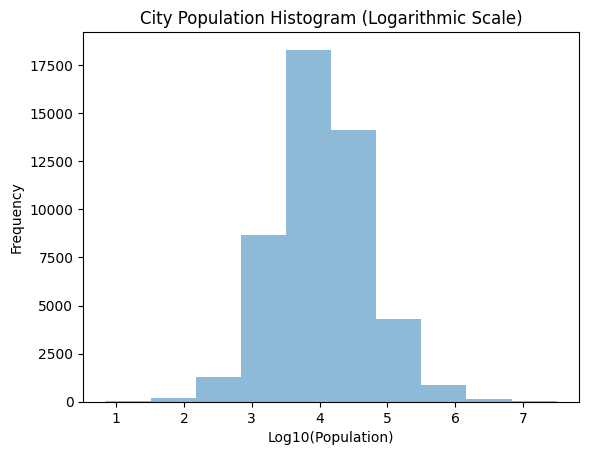

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10
import matplotlib.pyplot as plt


# Extract the "Population" column and apply a logarithmic transformation
populations = cleaned_df.select(log10(col("Population").cast("double")).alias("log_population"))

# Convert to Pandas DataFrame for plotting
populations_pd = populations.toPandas()

# Plot the histogram
plt.hist(populations_pd["log_population"], bins=10, alpha=0.5)
plt.title("City Population Histogram (Logarithmic Scale)")
plt.xlabel("Log10(Population)")
plt.ylabel("Frequency")
plt.show()


## TopK

In [84]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Select the columns needed for the calculation
top_cities_df = cleaned_df.select(
        col("Country"),
    col("City"),
    col("AccentCity"),
    col("Population").cast("int").alias("Population"),
    col('Region'),
    col('Latitude'),
    col('Longitude')
)

# Get the top 10 cities by population
top_10_cities = top_cities_df.orderBy(col("Population").desc()).limit(10)

# Show the result
top_10_cities.show()


+-------+---------+----------+----------+------+----------+----------+
|Country|     City|AccentCity|Population|Region|  Latitude| Longitude|
+-------+---------+----------+----------+------+----------+----------+
|     jp|    tokyo|     Tokyo|  31480498|    40|    35.685|139.751389|
|     cn| shanghai|  Shanghai|  14608512|    23| 31.045556|121.399722|
|     in|   bombay|    Bombay|  12692717|    16|    18.975| 72.825833|
|     pk|  karachi|   Karachi|  11627378|    05|   24.9056|   67.0822|
|     in|    delhi|     Delhi|  10928270|    07| 28.666667| 77.216667|
|     in|new delhi| New Delhi|  10928270|    07|      28.6|      77.2|
|     ph|   manila|    Manila|  10443877|    D9|   14.6042|  120.9822|
|     ru|   moscow|    Moscow|  10381288|    48| 55.752222| 37.615556|
|     kr|    seoul|     Seoul|  10323448|    11|   37.5985|  126.9783|
|     br|sao paulo| S�o Paulo|  10021437|    27|-23.473293|-46.665803|
+-------+---------+----------+----------+------+----------+----------+



## percentage of population

In [85]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Select the columns needed for the calculation
top_cities_df = cleaned_df.select(
    col("Country"),
    col("City"),
    col("Population").cast("int").alias("Population")
)

# Define the value of K
K = 10

# Calculate the total population
total_population = top_cities_df.agg({"Population": "sum"}).collect()[0][0]

# Calculate the total population of the top K cities
top_k_population = top_cities_df.orderBy(col("Population").desc()).limit(K).agg({"Population": "sum"}).collect()[0][0]

# Calculate the percentage
percentage = (top_k_population / total_population) * 100

print(f"The top {K} cities represent {percentage:.2f}% of the total population.")


The top 10 cities represent 5.83% of the total population.


The top 10 cities represent 5.83% of the total population globally.





In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Select the columns needed for the calculation
top_cities_df = cleaned_df.select(
    col("Country"),
    col("City"),
    col("Population").cast("int").alias("Population")
)

# Define the value of K
K = 10

# Calculate the total population
total_population = top_cities_df.agg({"Population": "sum"}).collect()[0][0]

# Calculate the total population of the top K cities
top_k_cities_df = top_cities_df.orderBy(col("Population").desc()).limit(K)
top_k_population = top_k_cities_df.agg({"Population": "sum"}).collect()[0][0]

# Calculate the percentage for each city
percentage_columns = [(col("Population") / total_population * 100).alias(f"Percentage") ]
result_df = top_k_cities_df.select("*", *percentage_columns)

# Show the result
result_df.show()


+-------+---------+----------+-------------------+
|Country|     City|Population|         Percentage|
+-------+---------+----------+-------------------+
|     jp|    tokyo|  31480498|  1.374943407375111|
|     cn| shanghai|  14608512| 0.6380419161717263|
|     in|   bombay|  12692717| 0.5543675821401554|
|     pk|  karachi|  11627378| 0.5078377961542541|
|     in|    delhi|  10928270|0.47730352901390577|
|     in|new delhi|  10928270|0.47730352901390577|
|     ph|   manila|  10443877| 0.4561471622395094|
|     ru|   moscow|  10381288|0.45341352273596025|
|     kr|    seoul|  10323448| 0.4508873007339266|
|     br|sao paulo|  10021437|0.43769665700888877|
+-------+---------+----------+-------------------+



## population of region

In [88]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Select the columns needed for the calculation
region_population_df = cleaned_df.select(
    col("Region"),
    col("Population").cast("int").alias("Population")
)

# Calculate the total population for each region
region_total_population = region_population_df.groupBy("Region").agg({"Population": "sum"}).orderBy(col("sum(Population)").desc())

# Find the region with the highest population
max_population_region = region_total_population.first()["Region"]

# Show the result
print("Total Population of Each Region:")
region_total_population.show()

print(f"\nThe region with the highest population is: {max_population_region}")


Total Population of Each Region:
+------+---------------+
|Region|sum(Population)|
+------+---------------+
|    04|      112249869|
|    07|       99634521|
|    02|       90271668|
|    05|       88272385|
|    16|       71422264|
|    08|       69386610|
|    09|       68742631|
|    11|       61477197|
|    01|       60187116|
|    06|       58191980|
|    15|       57366367|
|    10|       52912641|
|    13|       50762945|
|    19|       49067537|
|    23|       48056875|
|    30|       47565528|
|    25|       44541463|
|    12|       44192013|
|    40|       43122879|
|    27|       42540035|
+------+---------------+
only showing top 20 rows


The region with the highest population is: 04


Region with the highest population:
Region: 04, Total Population: 112249869
Total population by region:
1. Region: 04, Population: 112249869
2. Region: 07, Population: 99634521
3. Region: 02, Population: 90271668
4. Region: 05, Population: 88272385
5. Region: 16, Population: 71422264
6. Region: 08, Population: 69386610
7. Region: 09, Population: 68742631
8. Region: 11, Population: 61477197
9. Region: 01, Population: 60187116
10. Region: 06, Population: 58191980

## sum of population of cities > specific value


### specific value =1000000

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Select the columns needed for the calculation
country_population_df = cleaned_df.select(
    col("Country"),
    col("Population").cast("int").alias("Population")
)

# Define the specified value
specified_value = 1000000  # Adjust as needed

# Calculate the total population for each country
country_total_population = country_population_df.groupBy("Country").agg({"Population": "sum"})

# Filter countries where the sum of populations is greater than the specified value
selected_countries = country_total_population.filter(col("sum(Population)") > specified_value)

# Show the result
print(f"Countries with a total population greater than {specified_value}:")
selected_countries.show()


Countries with a total population greater than 1000000:
+-------+---------------+
|Country|sum(Population)|
+-------+---------------+
|     cr|        1895757|
|     eg|       20019903|
|     ge|        1712753|
|     cl|       11618910|
|     il|        3845875|
|     ba|        2899759|
|     jp|      101577008|
|     ao|        4315181|
|     by|        3860154|
|     cn|      218884084|
|     bd|       14717217|
|     ir|       29537978|
|     ke|        6269402|
|     kh|        1979948|
|     in|      259227307|
|     au|       17757915|
|     ae|        2285005|
|     iq|        7659405|
|     be|        9669713|
|     gb|       39640624|
+-------+---------------+
only showing top 20 rows



## condition + average

### threshold= 100000

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

# Select the columns needed for the calculation
country_population_df = cleaned_df.select(
    col("Country"),
    col("Population").cast("int").alias("Population")
)

# Define the population threshold
population_threshold = 100000  # Adjust as needed

# Filter cities with a population above the threshold
filtered_cities_df = country_population_df.filter(col("Population") > population_threshold)

# Calculate the average population for cities in each country
average_population_by_country = filtered_cities_df.groupBy("Country").agg(avg("Population").alias("AveragePopulation"))

# Show the result
print(f"Average population for cities in each country (population above {population_threshold}):")
average_population_by_country.show()


Average population for cities in each country (population above 100000):
+-------+------------------+
|Country| AveragePopulation|
+-------+------------------+
|     cr|          335056.0|
|     eg| 985530.3157894737|
|     ge|         1049516.0|
|     cl|          381148.0|
|     il|          243992.1|
|     bw|          208411.0|
|     cv|          111611.0|
|     ba|          265849.8|
|     jp|424524.70391061454|
|     ao|          596276.5|
|     by|        413884.875|
|     cn| 502467.7545691906|
|     gq|          164537.5|
|     bd| 603828.7894736842|
|     gm|          160297.5|
|     ir| 362731.8333333333|
|     ke| 726634.8333333334|
|     kh|         1573523.0|
|     in| 471983.8388746803|
|     au|1059004.0714285714|
+-------+------------------+
only showing top 20 rows



## population > country average

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg


# Select the columns needed for the calculation
city_population_df = cleaned_df.select(
        col("Country"),
    col("City"),
    col("AccentCity"),
    col("Population").cast("int").alias("Population"),
    col('Region'),
    col('Latitude'),
    col('Longitude')
)

# Calculate the average population for cities in each country
average_population_by_country = city_population_df.groupBy("Country").agg(avg("Population").alias("AveragePopulation"))

# Join the original DataFrame with the average population by country
joined_df = city_population_df.join(average_population_by_country, on="Country")

# Filter cities with a population above the average population of their respective countries
selected_cities = joined_df.filter(col("Population") > col("AveragePopulation"))

# Show the result
print("Cities with a population above the average population of their respective countries:")
selected_cities.show()


Cities with a population above the average population of their respective countries:
+-------+----------------+----------------+----------+------+---------+----------+------------------+
|Country|            City|      AccentCity|Population|Region| Latitude| Longitude| AveragePopulation|
+-------+----------------+----------------+----------+------+---------+----------+------------------+
|     cr|       turrialba|       Turrialba|     28960|    02| 9.904666|-83.683519|19543.886597938144|
|     cr|     san vicente|     San Vicente|     34453|    08| 9.960158| -84.04762|19543.886597938144|
|     cr|     san vicente|     San Vicente|     34453|    04|  9.98433| -84.08223|19543.886597938144|
|     cr|      san rafael|      San Rafael|     25415|    08| 9.875563|-84.076613|19543.886597938144|
|     cr|san rafael abajo|San Rafael Abajo|     27424|    08| 9.831002|-84.290079|19543.886597938144|
|     cr|       san pedro|       San Pedro|     27482|    08| 9.928293|-84.050735|19543.88659793814

## Re-cleaning

In [91]:
from pyspark.sql.functions import col, format_number

# Multiply Latitude and Longitude values by 10, truncate, and then divide by 10
rounded_df = cleaned_df.withColumn("Latitude", (col("Latitude") * 10).cast("int").cast("double") / 10)
rounded_df = rounded_df.withColumn("Longitude", (col("Longitude") * 10).cast("int").cast("double") / 10)


# Show the modified DataFrame
rounded_df.show()


+-------+-------------------+-------------------+------+----------+--------+---------+
|Country|               City|         AccentCity|Region|Population|Latitude|Longitude|
+-------+-------------------+-------------------+------+----------+--------+---------+
|     ad|   andorra la vella|   Andorra la Vella|    07|     20430|    42.5|      1.5|
|     ad|            canillo|            Canillo|    02|      3292|    42.5|      1.6|
|     ad|             encamp|             Encamp|    03|     11224|    42.5|      1.5|
|     ad|         la massana|         La Massana|    04|      7211|    42.5|      1.5|
|     ad|       les escaldes|       Les Escaldes|    08|     15854|    42.5|      1.5|
|     ad|             ordino|             Ordino|    05|      2553|    42.5|      1.5|
|     ad|sant julia de loria|Sant Juli� de L�ria|    06|      8020|    42.4|      1.5|
|     ae|          abu dhabi|          Abu Dhabi|    01|    603687|    24.4|     54.3|
|     ae|              dubai|              

In [119]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import math

# Assuming cleaned_df is your DataFrame with the original data
schema = ["Country", "AccentCity", "City", "Region", "Population", "Latitude", "Longitude"]

# Parse the DataFrame into the desired format
def parse_dataframe(row):
    latitude = math.floor(row["Latitude"] * 10) / 10
    longitude = math.floor(row["Longitude"] * 10) / 10
    country = row["Country"]
    region = row["Region"]
    return ((country, region, latitude, longitude), row)

parsed_data_rdd = cleaned_df.rdd.map(parse_dataframe).reduceByKey(lambda a, b: b if a["Population"] > b["Population"] else a).values()

# Convert RDD to DataFrame
result_df = parsed_data_rdd.map(lambda x: Row(**x.asDict())).toDF(schema)

# Show the result
result_df.show()


+-------+-------------------+-------------------+------+----------+----------+---------+
|Country|         AccentCity|               City|Region|Population|  Latitude|Longitude|
+-------+-------------------+-------------------+------+----------+----------+---------+
|     ad|   andorra la vella|   Andorra la Vella|    07|     20430|      42.5|1.5166667|
|     ad|             encamp|             Encamp|    03|     11224|42.5333333|1.5833333|
|     ad|             ordino|             Ordino|    05|      2553|     42.55|1.5333333|
|     ad|sant julia de loria|Sant Juli� de L�ria|    06|      8020|42.4666667|      1.5|
|     ae|          abu dhabi|          Abu Dhabi|    01|    603687| 24.466667|54.366667|
|     af|            andarab|            Andarab|    03|     27034| 35.633484|69.260195|
|     af|              asmar|              Asmar|    34|     15708| 35.033328|71.358087|
|     af|             baglan|             Baglan|    03|    108481| 36.130684|68.708286|
|     af|            

#### statistics

In [120]:
# Calculate statistics for city populations
statistics_df = result_df.select(
    col("Population").cast("int").alias("Population")
).describe(["Population"])

# Show the statistics DataFrame
statistics_df.show()

+-------+------------------+
|summary|        Population|
+-------+------------------+
|  count|             38510|
|   mean| 50216.33199169047|
| stddev|326295.50640076067|
|    min|                 7|
|    max|          31480498|
+-------+------------------+



Number of valid records: 38510


* Minimum Population: 7
* Maximum Population: 31480498
* Total Population: 1933830945
* Average Population: 50216.331991690415

#### histogram

In [125]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10

# Extract the "Population" column and apply a logarithmic transformation
populations = result_df.select(log10(col("Population").cast("double")).alias("log_population"))

# Extract the log-transformed population values as an RDD
log_populations_rdd = populations.rdd.flatMap(lambda x: x)

# Define the bins for the histogram using a logarithmic scale
bins = [i for i in range(0, 9)]

# Compute the histogram using Spark RDD's histogram method
hist_values = log_populations_rdd.histogram(bins)

# Create a dictionary from the histogram values
hist_dict = dict(zip(hist_values[0][:-1], hist_values[1]))

# Print the histogram as a dictionary
print(hist_dict)


{0: 5, 1: 115, 2: 1686, 3: 16155, 4: 17666, 5: 2640, 6: 234, 7: 9}


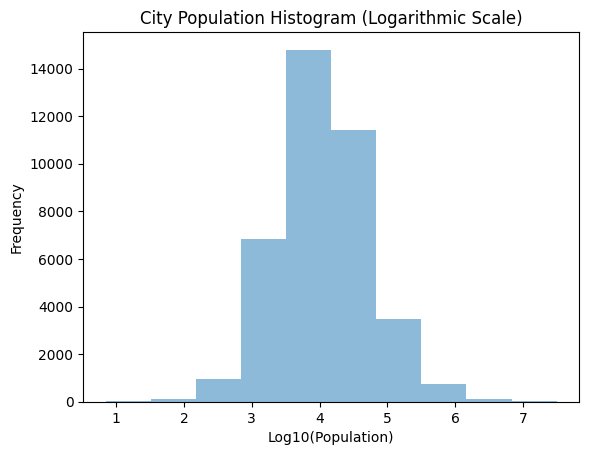

In [126]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10
import matplotlib.pyplot as plt


# Extract the "Population" column and apply a logarithmic transformation
populations = result_df.select(log10(col("Population").cast("double")).alias("log_population"))

# Convert to Pandas DataFrame for plotting
populations_pd = populations.toPandas()

# Plot the histogram
plt.hist(populations_pd["log_population"], bins=10, alpha=0.5)
plt.title("City Population Histogram (Logarithmic Scale)")
plt.xlabel("Log10(Population)")
plt.ylabel("Frequency")
plt.show()


#### top k

In [122]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Select the columns needed for the calculation
top_cities_df = result_df.select(
    col("Country"),
    col("City"),
    col("AccentCity"),
    col("Population").cast("int").alias("Population"),
    col('Region'),
    col('Latitude'),
    col('Longitude')
)

# Get the top 10 cities by population
top_10_cities = top_cities_df.orderBy(col("Population").desc()).limit(10)

# Show the result
top_10_cities.show()


+-------+---------+----------+----------+------+----------+----------+
|Country|     City|AccentCity|Population|Region|  Latitude| Longitude|
+-------+---------+----------+----------+------+----------+----------+
|     jp|    Tokyo|     tokyo|  31480498|    40|    35.685|139.751389|
|     cn| Shanghai|  shanghai|  14608512|    23| 31.045556|121.399722|
|     in|   Bombay|    bombay|  12692717|    16|    18.975| 72.825833|
|     pk|  Karachi|   karachi|  11627378|    05|   24.9056|   67.0822|
|     in|    Delhi|     delhi|  10928270|    07| 28.666667| 77.216667|
|     ph|   Manila|    manila|  10443877|    D9|   14.6042|  120.9822|
|     ru|   Moscow|    moscow|  10381288|    48| 55.752222| 37.615556|
|     kr|    Seoul|     seoul|  10323448|    11|   37.5985|  126.9783|
|     br|S�o Paulo| sao paulo|  10021437|    27|-23.473293|-46.665803|
|     tr| Istanbul|  istanbul|   9797536|    34| 41.018611| 28.964722|
+-------+---------+----------+----------+------+----------+----------+



#### percentage of population

In [124]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Select the columns needed for the calculation
top_cities_df = result_df.select(
    col("Country"),
    col("City"),
    col("Population").cast("int").alias("Population")
)

# Define the value of K
K = 5

# Calculate the total population
total_population = top_cities_df.agg({"Population": "sum"}).collect()[0][0]

# Calculate the total population of the top K cities
top_k_population = top_cities_df.orderBy(col("Population").desc()).limit(K).agg({"Population": "sum"}).collect()[0][0]

# Calculate the percentage
percentage = (top_k_population / total_population) * 100

print(f"The top {K} cities represent {percentage:.2f}% of the total population.")


The top 5 cities represent 4.21% of the total population.


Percentage of total population represented by the top 5 populous cities: 4.21%

In [127]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
final_df=result_df
# Select the columns needed for the calculation
top_cities_df = final_df.select(
    col("Country"),
    col("City"),
    col("Population").cast("int").alias("Population")
)

# Define the value of K
K = 10

# Calculate the total population
total_population = top_cities_df.agg({"Population": "sum"}).collect()[0][0]

# Calculate the total population of the top K cities
top_k_cities_df = top_cities_df.orderBy(col("Population").desc()).limit(K)
top_k_population = top_k_cities_df.agg({"Population": "sum"}).collect()[0][0]

# Calculate the percentage for each city
percentage_columns = [(col("Population") / total_population * 100).alias(f"Percentage") ]
result_df = top_k_cities_df.select("*", *percentage_columns)

# Show the result
result_df.show()


+-------+---------+----------+------------------+
|Country|     City|Population|        Percentage|
+-------+---------+----------+------------------+
|     jp|    Tokyo|  31480498|1.6278826275582223|
|     cn| Shanghai|  14608512|0.7554182560668455|
|     in|   Bombay|  12692717|0.6563509097223594|
|     pk|  Karachi|  11627378|0.6012613475889952|
|     in|    Delhi|  10928270|0.5651098938226992|
|     ph|   Manila|  10443877|0.5400615305594875|
|     ru|   Moscow|  10381288|0.5368250015256634|
|     kr|    Seoul|  10323448|0.5338340472155388|
|     br|S�o Paulo|  10021437|0.5182168082432873|
|     tr| Istanbul|   9797536|0.5066387020712403|
+-------+---------+----------+------------------+



#### population of region

In [128]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Select the columns needed for the calculation
region_population_df = final_df.select(
    col("Region"),
    col("Population").cast("int").alias("Population")
)

# Calculate the total population for each region
region_total_population = region_population_df.groupBy("Region").agg({"Population": "sum"}).orderBy(col("sum(Population)").desc())

# Find the region with the highest population
max_population_region = region_total_population.first()["Region"]

# Show the result
print("Total Population of Each Region:")
region_total_population.show()

print(f"\nThe region with the highest population is: {max_population_region}")


Total Population of Each Region:
+------+---------------+
|Region|sum(Population)|
+------+---------------+
|    04|       95893419|
|    02|       83399132|
|    05|       81248168|
|    07|       75975207|
|    08|       62700707|
|    16|       62699388|
|    11|       54529402|
|    06|       53469380|
|    09|       52841233|
|    01|       50468386|
|    10|       47092683|
|    15|       46829081|
|    19|       44188922|
|    13|       43253826|
|    23|       42607793|
|    12|       41011644|
|    40|       40524146|
|    30|       38080442|
|    27|       36956815|
|    25|       36229585|
+------+---------------+
only showing top 20 rows


The region with the highest population is: 04


#### sum of pop > thrsh

In [129]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Select the columns needed for the calculation
country_population_df = final_df.select(
    col("Country"),
    col("Population").cast("int").alias("Population")
)

# Define the specified value
specified_value = 1000000  # Adjust as needed

# Calculate the total population for each country
country_total_population = country_population_df.groupBy("Country").agg({"Population": "sum"})

# Filter countries where the sum of populations is greater than the specified value
selected_countries = country_total_population.filter(col("sum(Population)") > specified_value)

# Show the result
print(f"Countries with a total population greater than {specified_value}:")
selected_countries.show()


Countries with a total population greater than 1000000:
+-------+---------------+
|Country|sum(Population)|
+-------+---------------+
|     mz|        4493885|
|     us|      121069136|
|     eg|       20019903|
|     ne|        2675929|
|     ge|        1698328|
|     cl|       11446732|
|     il|        2404337|
|     ro|        9754429|
|     uz|        5199064|
|     ba|        1617803|
|     jp|       79838975|
|     ao|        4315181|
|     by|        3860154|
|     lv|        1535847|
|     vn|       11824993|
|     pl|       18957580|
|     cn|      215141618|
|     za|       28161751|
|     sk|        2664116|
|     bd|       14717217|
+-------+---------------+
only showing top 20 rows



#### condition + average

In [130]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

# Select the columns needed for the calculation
country_population_df = final_df.select(
    col("Country"),
    col("Population").cast("int").alias("Population")
)

# Define the population threshold
population_threshold = 100000  # Adjust as needed

# Filter cities with a population above the threshold
filtered_cities_df = country_population_df.filter(col("Population") > population_threshold)

# Calculate the average population for cities in each country
average_population_by_country = filtered_cities_df.groupBy("Country").agg(avg("Population").alias("AveragePopulation"))

# Show the result
print(f"Average population for cities in each country (population above {population_threshold}):")
average_population_by_country.show()


Average population for cities in each country (population above 100000):
+-------+------------------+
|Country| AveragePopulation|
+-------+------------------+
|     ye|          550744.0|
|     mz|          345529.0|
|     us|383695.39455782314|
|     eg| 985530.3157894737|
|     ne|         475857.75|
|     ge|         1049516.0|
|     cl|          381148.0|
|     il| 271553.8333333333|
|     bw|          208411.0|
|     ro|          211799.0|
|     uz|          459440.0|
|     cv|          111611.0|
|     ba|          192761.0|
|     jp| 534667.6363636364|
|     ao|          596276.5|
|     by|        413884.875|
|     lv|          427067.0|
|     vn| 352194.6896551724|
|     pl|      289789.15625|
|     cn|506517.72654155496|
+-------+------------------+
only showing top 20 rows



#### population > avg

In [131]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg


# Select the columns needed for the calculation
city_population_df = final_df.select(
        col("Country"),
    col("City"),
    col("AccentCity"),
    col("Population").cast("int").alias("Population"),
    col('Region'),
    col('Latitude'),
    col('Longitude')
)

# Calculate the average population for cities in each country
average_population_by_country = city_population_df.groupBy("Country").agg(avg("Population").alias("AveragePopulation"))

# Join the original DataFrame with the average population by country
joined_df = city_population_df.join(average_population_by_country, on="Country")

# Filter cities with a population above the average population of their respective countries
selected_cities = joined_df.filter(col("Population") > col("AveragePopulation"))

# Show the result
print("Cities with a population above the average population of their respective countries:")
selected_cities.show()


Cities with a population above the average population of their respective countries:
+-------+-----------------+-----------------+----------+------+----------+----------+------------------+
|Country|             City|       AccentCity|Population|Region|  Latitude| Longitude| AveragePopulation|
+-------+-----------------+-----------------+----------+------+----------+----------+------------------+
|     ye|             Aden|             aden|    550744|    02|12.7794444|45.0366667|112429.28571428571|
|     cr|      San Vicente|      san vicente|     34453|    04|   9.98433| -84.08223|11959.935483870968|
|     cr| San Rafael Abajo| san rafael abajo|     27424|    08|  9.831002|-84.290079|11959.935483870968|
|     cr|         San Jos�|         san jose|     31430|    01| 10.951731|-85.136096|11959.935483870968|
|     cr|      San Antonio|      san antonio|     12965|    04|  9.983333|-84.183333|11959.935483870968|
|     cr|            Lim�n|            limon|     63094|    06|  9.992861|-